In [1]:
import collections

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pamtra2

try:
    %matplotlib inline
except:
    pass


# Define functions & import WRF

In [2]:
wrfHydrometeors = ['CLOUD','RAIN','ICE','SNOW']#,'GRAUP']

wrfRenameDim = {
    'bottom_top_stag':'level',
    'bottom_top':'layer',
    'Time' : 'time',
}


def linLevel2layer(var):
    var= (var.isel(level=np.s_[:-1]) +  0.5 * var.diff('level'))
    return var.rename({'level':'layer'})


from pamtra2.libs.meteo_si.constants import Rair

In [3]:
wrfDat = xr.open_dataset('../data/WRF/2017-08-25/Barrow.nc')
#fix time
wrfDat['Time'] = [np.datetime64(str(x).replace('_','T').replace("'",'').replace("b",''))
                          for x in wrfDat.Times.values]
wrfDat = wrfDat.drop('Times')
wrfDat = wrfDat.rename(wrfRenameDim)

wrfDat = wrfDat.squeeze()

# Create pamtra2 object and fill atmospheric profiles with WRF values

In [4]:
additionalDims = collections.OrderedDict()
additionalDims['time'] = wrfDat['time'].values
nHeights = len(wrfDat.layer)

pam2 = pamtra2.pamtra2(
    nLayer=nHeights,
    hydrometeors=wrfHydrometeors,
    additionalDims = additionalDims,
    frequencies = [35e9],
)




In [5]:
pam2.profile

<xarray.customProfile>
Dimensions:              (frequency: 1, hydrometeor: 4, layer: 39, time: 41)
Coordinates:
  * time                 (time) datetime64[ns] 2017-08-25 ...
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * hydrometeor          (hydrometeor) <U5 'CLOUD' 'RAIN' 'ICE' 'SNOW'
  * frequency            (frequency) float64 3.5e+10
Data variables:
    height               (time, layer) float64 nan nan nan nan nan nan nan ...
    temperature          (time, layer) float64 nan nan nan nan nan nan nan ...
    pressure             (time, layer) float64 nan nan nan nan nan nan nan ...
    relativeHumidity     (time, layer) float64 nan nan nan nan nan nan nan ...
    horizontalWind       (time, layer) float64 nan nan nan nan nan nan nan ...
    verticalWind         (time, layer) float64 nan nan nan nan nan nan nan ...
    eddyDissipationRate  (time, layer) float64 nan nan nan nan nan nan nan ...
    hydrometeorContent   (time, layer, hydrometeor)

In [6]:

heights = linLevel2layer((wrfDat["PH"]+wrfDat["PHB"])/9.81)
pressure = (wrfDat["P"] + wrfDat["PB"])


Cp = 7.*Rair/2.
RdCp =  Rair/Cp
p0 = 100000
T0 = wrfDat["T00"]
temperature = (wrfDat["T"] + T0)*(pressure/p0)**RdCp # potential temp to temp
temperature = temperature

horizontalWind = np.sqrt(wrfDat.V**2 + wrfDat.U**2)

mixingRatio = wrfDat.QVAPOR
specHum = mixingRatio/(1+mixingRatio)
relHum = pamtra2.libs.meteo_si.humidity.q2rh(specHum,temperature,pressure) * 100

pam2.profile.height[:] = heights
pam2.profile.temperature[:] = temperature
pam2.profile.relativeHumidity[:] = relHum # >200%?? but hardly relevant for radar simulator...
pam2.profile.pressure[:] = pressure
pam2.profile.eddyDissipationRate[:] = 1e-4 # not included in model output, 
pam2.profile.horizontalWind[:] =horizontalWind

pam2.addAirDensity()

pam2.profile['hydrometeorNumberConc'] = xr.zeros_like(pam2.profile.hydrometeorContent)

for hh, hydro in enumerate(wrfHydrometeors):
    
    pam2.profile.hydrometeorContent.values[...,hh] = wrfDat['Q%s'%hydro] * pam2.profile.airDensity
    if hydro not in ['CLOUD','GRAUP']:
        pam2.profile.hydrometeorNumberConc.values[...,hh] = wrfDat['QN%s'%hydro] * pam2.profile.airDensity
    elif hydro == 'CLOUD':
        cond = wrfDat['Q%s'%hydro]>0
        pam2.profile.hydrometeorNumberConc.values[cond,hh] = 2.5e8

pam2.addMissingVariables()


pam2.profile


<xarray.customProfile>
Dimensions:                (frequency: 1, hydrometeor: 4, layer: 39, time: 41)
Coordinates:
  * time                   (time) datetime64[ns] 2017-08-25 ...
  * layer                  (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * hydrometeor            (hydrometeor) <U5 'CLOUD' 'RAIN' 'ICE' 'SNOW'
  * frequency              (frequency) float64 3.5e+10
Data variables:
    height                 (time, layer) float64 17.22 45.41 81.28 127.4 ...
    temperature            (time, layer) float64 264.9 264.5 264.0 263.6 ...
    pressure               (time, layer) float64 1.009e+05 1.005e+05 ...
    relativeHumidity       (time, layer) float64 192.7 195.8 199.6 202.8 ...
    horizontalWind         (time, layer) float64 6.275 6.559 6.92 7.12 7.459 ...
    verticalWind           (time, layer) float64 nan nan nan nan nan nan nan ...
    eddyDissipationRate    (time, layer) float64 0.0001 0.0001 0.0001 0.0001 ...
    hydrometeorContent     (time, layer, hydromete

# define hydrometeors
## cloud droplets

In [7]:
def WRF_cloud_N(
    sizeCenter,
    hydrometeorContent,
    hydrometeorNumberConc,
    airDensity,
    temperature,
    pressure
):
    '''
    Estimate the PSD in accordance with the WRF Morrison double moment scheme. 
    '''
    RHOW  = 997.;
    CONS26 = np.pi/6*RHOW
    QCLOUD = hydrometeorContent /airDensity
    QNCLOUD = hydrometeorNumberConc/airDensity

    DUM=pressure/(287.15*temperature)
    PGAM = 0.0005714*(QNCLOUD/1.e6*DUM)+0.2714
    PGAM = 1.0/(PGAM*PGAM) - 1.0
    PGAM.values[PGAM.values<2] = 2
    PGAM.values[PGAM.values>10] = 10

    LAMC = (CONS26*QNCLOUD*scipy.special.gamma(PGAM+4)/QCLOUD/scipy.special.gamma(PGAM+1))**(1./3.)
    N0C  = QNCLOUD*LAMC

    f = airDensity*N0C * (np.exp(-LAMC*sizeCenter)) 
    return f



pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidFixedDensity,
    name = 'CLOUD', #or None, then str(index)
    nBins =50,
    sizeBounds = pamtra2.hydrometeors.size.linspaceBounds, 
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    #add custom function here:
    sizeDistribution = WRF_cloud_N, 
    aspectRatio = 1.0,
    mass = pamtra2.hydrometeors.mass.ellipsoid,
    density = pamtra2.hydrometeors.density.water,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
    relativePermittivity = pamtra2.libs.refractiveIndex.water.turner_kneifel_cadeddu, 
    scattering = pamtra2.hydrometeors.scattering.Rayleigh,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.khvorostyanov01_drops,
    Dmin  = 1e-6,
    Dmax  = 0.008,
    useFuncArgDefaults = True,
)



sizeBounds <function linspaceBounds at 0x7f13c6408d90>
callable
sizeCenter <function boundsToMid at 0x7f13c6408ea0>
callable
sizeBoundsWidth <function boundsWidth at 0x7f13c6408f28>
callable
aspectRatio 1.0
not callable 1.0
density 1000.0
not callable 1000.0
mass <function ellipsoid at 0x7f13c640d2f0>
callable
crossSectionArea <function sphere at 0x7f13c640d9d8>
callable
sizeDistribution <function WRF_cloud_N at 0x7f13cc5360d0>
callable
relativePermittivity <function turner_kneifel_cadeddu at 0x7f13c668a0d0>
callable
scattering <function Rayleigh at 0x7f13c640de18>
callable
fallVelocity <function khvorostyanov01_drops at 0x7f13c640df28>
callable
nBins 50
not callable 50
Dmin 1e-06
not callable 1e-06
Dmax 0.008
not callable 0.008


/home/vagrant/miniconda/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


## rain

In [8]:
def WRF_rain_N(
    sizeCenter,
    hydrometeorContent,
    hydrometeorNumberConc,
    airDensity,
):
    '''
    Estimate the PSD in accordance with the WRF Morrison double moment scheme. 
    '''
    RHOW  = 997.
    QRAIN = hydrometeorContent /airDensity
    QNRAIN = hydrometeorNumberConc/airDensity

    LAMR  = (np.pi*RHOW*QNRAIN/QRAIN)**(1/3.)
    N0R   =   QNRAIN * LAMR

    f = airDensity*N0R * (np.exp(-LAMR*sizeCenter)) 
    return f


pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidFixedDensity,
    name = 'RAIN', #or None, then str(index)
    nBins =50,
    sizeBounds = pamtra2.hydrometeors.size.linspaceBounds, 
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    #add custom function here:
    sizeDistribution = WRF_rain_N, 
    aspectRatio = 1.0,
    mass = pamtra2.hydrometeors.mass.ellipsoid,
    density = pamtra2.hydrometeors.density.water,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
    relativePermittivity = pamtra2.libs.refractiveIndex.water.turner_kneifel_cadeddu, 
    scattering = pamtra2.hydrometeors.scattering.Rayleigh,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.khvorostyanov01_drops,
    Dmin  = 1e-6,
    Dmax  = 0.008,
    useFuncArgDefaults = True,
)

sizeBounds <function linspaceBounds at 0x7f13c6408d90>
callable
sizeCenter <function boundsToMid at 0x7f13c6408ea0>
callable
sizeBoundsWidth <function boundsWidth at 0x7f13c6408f28>
callable
aspectRatio 1.0
not callable 1.0
density 1000.0
not callable 1000.0
mass <function ellipsoid at 0x7f13c640d2f0>
callable
crossSectionArea <function sphere at 0x7f13c640d9d8>
callable
sizeDistribution <function WRF_rain_N at 0x7f13c186a8c8>
callable
relativePermittivity <function turner_kneifel_cadeddu at 0x7f13c668a0d0>
callable
scattering <function Rayleigh at 0x7f13c640de18>
callable
fallVelocity <function khvorostyanov01_drops at 0x7f13c640df28>
callable
nBins 50
not callable 50
Dmin 1e-06
not callable 1e-06
Dmax 0.008
not callable 0.008


/home/vagrant/miniconda/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


## ice

In [9]:
def WRF_ice_N(
    sizeCenter,
    hydrometeorContent,
    hydrometeorNumberConc,
    airDensity,
    density,
):
    '''
    Estimate the PSD in accordance with the WRF Morrison double moment scheme. 
    '''
    RHOI  = density
    QICE = hydrometeorContent /airDensity
    QNICE = hydrometeorNumberConc/airDensity

    CI = RHOI*np.pi/6.
    DI = 3.0
    CONS2  = CI*scipy.special.gamma(1.+DI)
    LAMI = (CONS2*QNICE/QICE)**(1./3.)
    N0I  = QNICE*LAMI

    f = airDensity*N0I * (np.exp(-LAMI*sizeCenter))
    return f


pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidFixedDensity,
    name = 'ICE', #or None, then str(index)
    nBins =50,
    sizeBounds = pamtra2.hydrometeors.size.linspaceBounds, 
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    #add custom function here:
    sizeDistribution = WRF_ice_N, 
    aspectRatio = 1.0,
    mass = pamtra2.hydrometeors.mass.ellipsoid,
    density = 500,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
    relativePermittivity = pamtra2.libs.refractiveIndex.snow.eps, 
    scattering = pamtra2.hydrometeors.scattering.Rayleigh,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.heymsfield10_particles,
    Dmin  = 1e-6,
    Dmax  = 4.04e-2,
    useFuncArgDefaults = True,
    matzlerCheckTemperature=False
)

sizeBounds <function linspaceBounds at 0x7f13c6408d90>
callable
sizeCenter <function boundsToMid at 0x7f13c6408ea0>
callable
sizeBoundsWidth <function boundsWidth at 0x7f13c6408f28>
callable
aspectRatio 1.0
not callable 1.0
density 500
not callable 500
mass <function ellipsoid at 0x7f13c640d2f0>
callable
crossSectionArea <function sphere at 0x7f13c640d9d8>
callable
sizeDistribution <function WRF_ice_N at 0x7f13c182d048>
callable
relativePermittivity <function eps at 0x7f13c6676ae8>
callable
scattering <function Rayleigh at 0x7f13c640de18>
callable
fallVelocity <function heymsfield10_particles at 0x7f13c640dea0>
callable
nBins 50
not callable 50
Dmin 1e-06
not callable 1e-06
Dmax 0.0404
not callable 0.0404
matzlerCheckTemperature False
not callable False


/home/vagrant/miniconda/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


## snow

In [10]:
def WRF_snow_N(
    sizeCenter,
    hydrometeorContent,
    hydrometeorNumberConc,
    airDensity,
    density,
):
    '''
    Estimate the PSD in accordance with the WRF Morrison double moment scheme. 
    '''
    RHOSN  = density
    QSNOW = hydrometeorContent /airDensity
    QNSNOW = hydrometeorNumberConc/airDensity
    
    DS = 3.0
    CS = RHOSN*np.pi/6.
    CONS1  = CS*scipy.special.gamma(1.+DS)
    LAMS  = (CONS1*QNSNOW/QSNOW)**(1./3.)
    N0S   =   QNSNOW * LAMS
    
    f = airDensity*N0S * (np.exp(-LAMS*sizeCenter))
    return f


pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidFixedDensity,
    name = 'SNOW', #or None, then str(index)
    nBins =50,
    sizeBounds = pamtra2.hydrometeors.size.linspaceBounds, 
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    #add custom function here:
    sizeDistribution = WRF_snow_N, 
    aspectRatio = 1.0,
    mass = pamtra2.hydrometeors.mass.ellipsoid,
    density = 100,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
    relativePermittivity = pamtra2.libs.refractiveIndex.snow.eps, 
    scattering = pamtra2.hydrometeors.scattering.Rayleigh,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.heymsfield10_particles,
    Dmin  = 1e-6,
    Dmax  = 4.04e-2,
    useFuncArgDefaults = True,
    matzlerCheckTemperature=False
)

sizeBounds <function linspaceBounds at 0x7f13c6408d90>
callable
sizeCenter <function boundsToMid at 0x7f13c6408ea0>
callable
sizeBoundsWidth <function boundsWidth at 0x7f13c6408f28>
callable
aspectRatio 1.0
not callable 1.0
density 100
not callable 100
mass <function ellipsoid at 0x7f13c640d2f0>
callable
crossSectionArea <function sphere at 0x7f13c640d9d8>
callable
sizeDistribution <function WRF_snow_N at 0x7f13c183dd08>
callable
relativePermittivity <function eps at 0x7f13c6676ae8>
callable
scattering <function Rayleigh at 0x7f13c640de18>
callable
fallVelocity <function heymsfield10_particles at 0x7f13c640dea0>
callable
nBins 50
not callable 50
Dmin 1e-06
not callable 1e-06
Dmax 0.0404
not callable 0.0404
matzlerCheckTemperature False
not callable False


/home/vagrant/miniconda/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


plot some size distributions for checking

(1, 50)

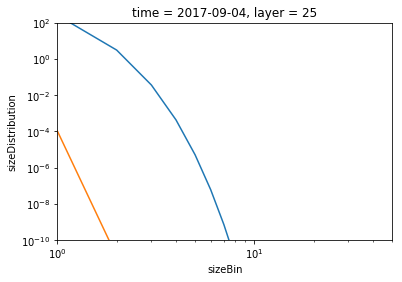

In [21]:
pam2.hydrometeors.SNOW.profile.sizeDistribution[-1,-14].plot()
pam2.hydrometeors.ICE.profile.sizeDistribution[-1,-14].plot()
plt.loglog()
plt.ylim(1e-10,1e2)
plt.xlim(1,50)

# add simple radar simulator

In [12]:

pam2.addInstrument(
    pamtra2.instruments.radar.simpleRadar,
    name = 'simple',
    frequencies = 35e9,    
        radarK2=0.93,    
)

/home/vagrant/miniconda/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


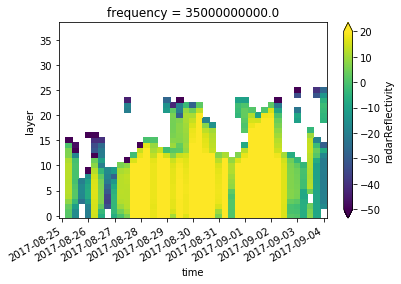

In [13]:
pam2.instruments.simple.results.radarReflectivity.T.plot(vmin=-50,vmax=20)